In [1]:
# basic modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
from pprint import pprint

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score 
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix

# models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier

#settings
warnings.filterwarnings('ignore')
rs = 42
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)
c = StratifiedKFold(n_splits=3)

In [2]:
df = pd.read_csv('./data/mimic_premodel.csv')

In [3]:
df.head()

,label,hadm_id,icustay_id,age,numb_diagn,los,tracheo,PaO2,base_excess,creatinin,...,leuko,mean_insp_pr,resp_rat,tidal_vol,breath_min_vol,ismale,icu_CSRU,icu_MICU,icu_SICU,icu_TSICU
0,1,100016,217590,56.0,11,6.1731,1,86.0,2.0,1.1,...,10.7,6.0,18.0,653.0,11.754,1,0,1,0,0
1,1,100017,258320,28.0,8,0.6924,0,171.0,4.0,0.8,...,9.3,6.4,20.0,430.0,8.600,1,0,1,0,0
2,1,100035,245719,37.0,26,10.5061,0,39.0,10.0,1.1,...,17.2,6.0,16.0,151.0,2.416,1,0,1,0,0
3,1,100063,241782,46.0,11,1.6501,0,365.0,2.0,1.0,...,8.4,1.0,18.0,441.0,7.938,1,0,1,0,0
4,1,100087,294404,57.0,18,3.7287,0,143.0,5.0,0.7,...,8.5,7.0,17.0,481.0,8.177,1,0,0,0,0


# New features

## Weight


## Work of Breathing

Work of breathing (WOB) is the energy expended to inhale and exhale a breathing gas. 
Work of breathing is the product of pressure and volume for each breath.

In [4]:
df.eval('wob = mean_insp_pr * tidal_vol* 0.000133', inplace=True)

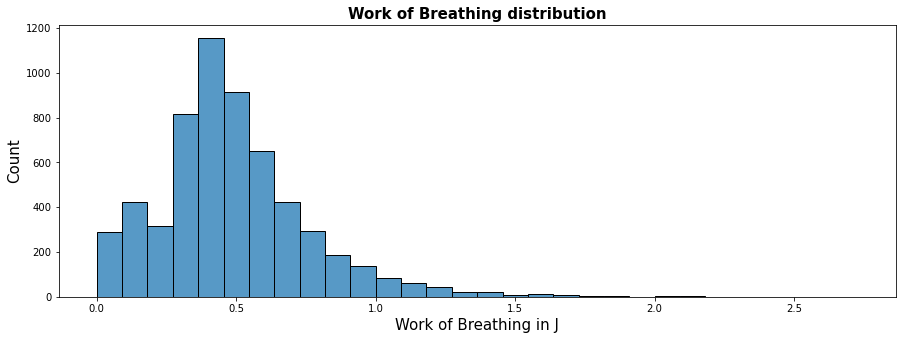

In [5]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.wob, bins=30)
ax.set_title("Work of Breathing distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Work of Breathing in J', fontsize=15);

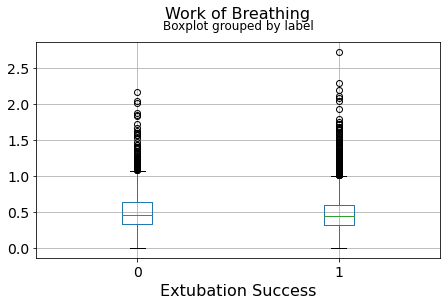

In [6]:
df.boxplot("wob",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Work of Breathing'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Rapid Shallow Breathing Index

The rapid shallow breathing index (RSBI) is a tool that is used in the weaning of mechanical ventilation on intensive care units.
The RSBI is defined as the ratio of respiratory frequency to tidal volume.

In [7]:
df.eval('rsbi = resp_rat / tidal_vol * 1000', inplace=True)

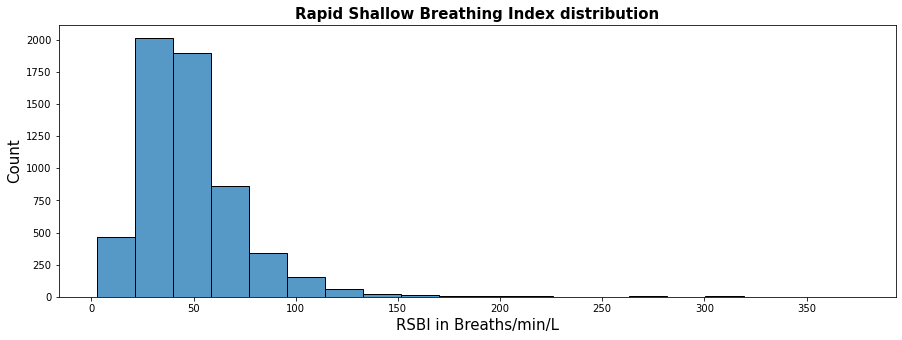

In [8]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.rsbi[df.rsbi < 400], bins=20)
ax.set_title("Rapid Shallow Breathing Index distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('RSBI in Breaths/min/L', fontsize=15);

In [9]:
len(df[df.rsbi>400])

25

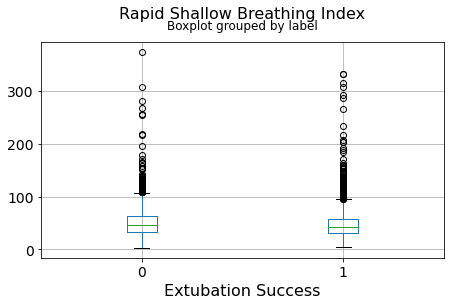

In [10]:
df[df.rsbi<400].boxplot("rsbi",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Rapid Shallow Breathing Index'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Duration of Ventilation

## Respiratory instability = PF Ratio

In [11]:
df.eval('pf_ratio =  PaO2/ FiO2 ', inplace=True)

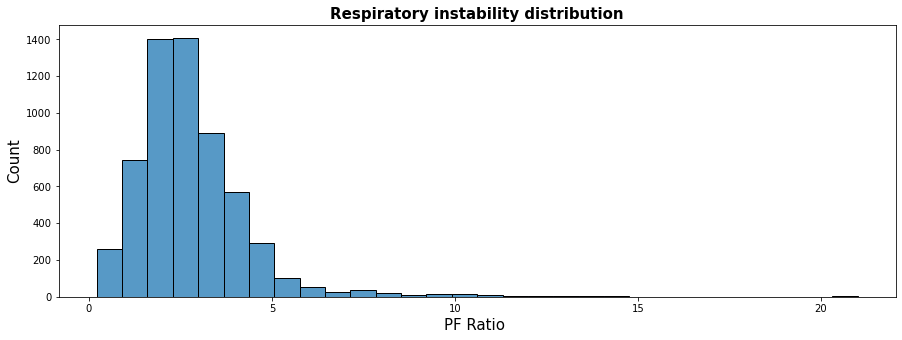

In [12]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.pf_ratio, bins=30)
ax.set_title("Respiratory instability distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('PF Ratio ', fontsize=15);

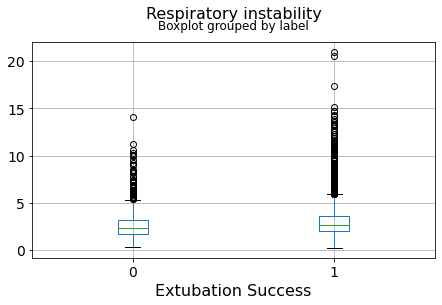

In [13]:
df.boxplot("pf_ratio",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Respiratory instability'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Product 1

In [14]:
df.eval('product1 = leuko*rsbi*FiO2 ', inplace=True)

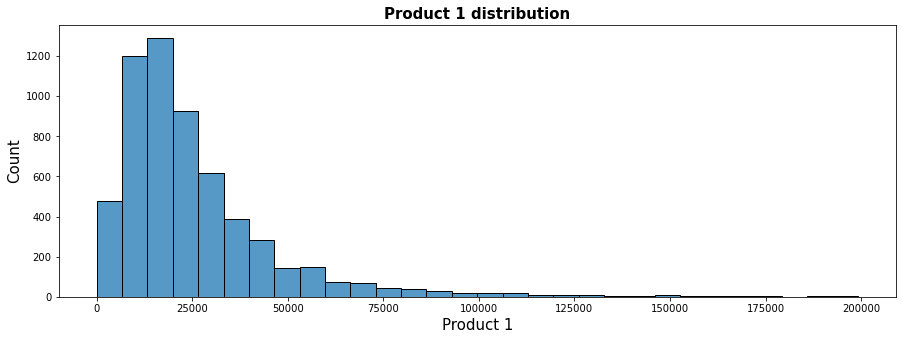

In [15]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.product1[df.product1<200000], bins=30)
ax.set_title("Product 1 distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Product 1', fontsize=15);

In [16]:
len(df[df.product1>200000])

38

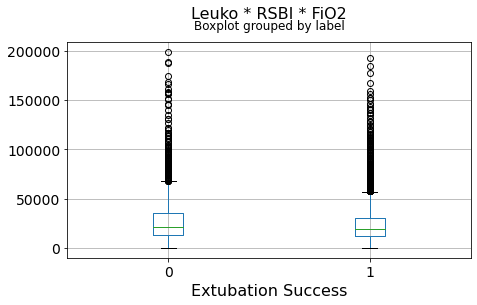

In [17]:
df[df.product1<200000].boxplot("product1",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Leuko * RSBI * FiO2'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Product 2

In [18]:
df.eval('product2 = hr * pf_ratio * wob ', inplace=True)

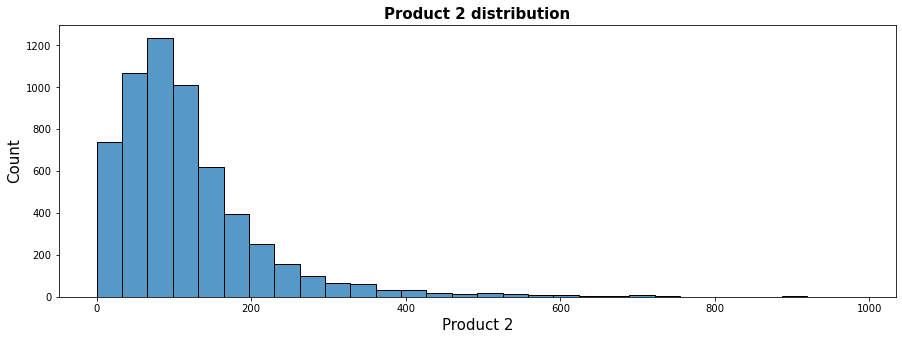

In [19]:
plt.figure(figsize=(15,5))
ax = sns.histplot(df.product2[df.product2<1000], bins=30)
ax.set_title("Product 2 distribution", fontsize=15, fontweight="bold")
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Product 2', fontsize=15);

In [20]:
len(df[df.product2>1000])

6

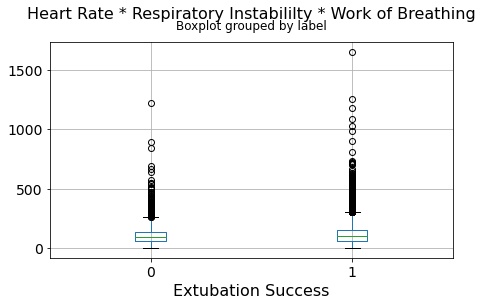

In [21]:
df.boxplot("product2",by= "label",figsize=(7,4),fontsize=14)
plt.title("{}\n".format('Heart Rate * Respiratory Instabililty * Work of Breathing'),fontsize=16)
plt.xlabel("Extubation Success", fontsize=16);

## Certain diseases

In [22]:
df_disease = pd.read_csv('./data/Comorbidities_MIMIC_patients.csv')

In [23]:
df_disease.head()

,hadm_id,diabetes,renal_failure,pneumonia,heart_failure,embolism
0,100016,0,0,0,0,0
1,100017,0,0,0,0,0
2,100035,0,0,0,1,0
3,100035,0,0,0,1,0
4,100063,0,0,0,0,0


In [24]:
df_disease.shape

(8477, 6)

In [26]:
df= df.merge(right=df_disease, how= 'inner' , on='hadm_id')

In [27]:
df.head()

,label,hadm_id,icustay_id,age,numb_diagn,los,tracheo,PaO2,base_excess,creatinin,...,wob,rsbi,pf_ratio,product1,product2,diabetes,renal_failure,pneumonia,heart_failure,embolism
0,1,100016,217590,56.0,11,6.1731,1,86.0,2.0,1.1,...,0.521094,27.565084,2.457143,10323.124043,116.516618,0,0,0,0,0
1,1,100017,258320,28.0,8,0.6924,0,171.0,4.0,0.8,...,0.366016,46.511628,4.275000,17302.325839,104.836133,0,0,0,0,0
2,1,100035,245719,37.0,26,10.5061,0,39.0,10.0,1.1,...,0.120498,105.960265,0.557143,127576.158940,5.437903,0,0,0,1,0
3,1,100035,245719,37.0,26,10.5061,0,39.0,10.0,1.1,...,0.120498,105.960265,0.557143,127576.158940,5.437903,0,0,0,1,0
4,1,100063,241782,46.0,11,1.6501,0,365.0,2.0,1.0,...,0.058653,40.816327,7.300000,17142.857143,32.540684,0,0,0,0,0


In [28]:
df.shape

(7579, 38)

In [29]:
df.icustay_id.nunique()

5884

In [30]:
df.drop_duplicates(inplace=True)

In [31]:
df.columns

Index(['label', 'hadm_id', 'icustay_id', 'age', 'numb_diagn', 'los', 'tracheo',
       'PaO2', 'base_excess', 'creatinin', 'hb', 'pH', 'FiO2', 'PEEP', 'SaO2',
       'blood_pr', 'hr', 'lactic_acid', 'leuko', 'mean_insp_pr', 'resp_rat',
       'tidal_vol', 'breath_min_vol', 'ismale', 'icu_CSRU', 'icu_MICU',
       'icu_SICU', 'icu_TSICU', 'wob', 'rsbi', 'pf_ratio', 'product1',
       'product2', 'diabetes', 'renal_failure', 'pneumonia', 'heart_failure',
       'embolism'],
      dtype='object')

In [32]:
liste = ['diabetes', 'kidney_failure', 'pneumonia','heart_failure', 'embolism']
sns.set(style="darkgrid")
fig, ax =plt.subplots(5,1, figsize=(8,16) ) 
max_count = max([max(df[i].value_counts()) for i in liste])
A=sns.countplot(y=df['diabetes'],ax=ax[0],order=df.diabetes.value_counts().iloc[:2].index)
B=sns.countplot(y=df['kidney_failure'],ax=ax[1],order=df.kidney_failure.value_counts().iloc[:2].index)
C=sns.countplot(y=df['pneumonia'],ax=ax[2],order=df.pneumonia.value_counts().iloc[:2].index)
D=sns.countplot(y=df['heart_failure'],ax=ax[3],order=df.heart_failure.value_counts().iloc[:2].index)
E=sns.countplot(y=df['embolism'],ax=ax[4],order=df.embolism.value_counts().iloc[:2].index)
ax[0].set_xlim(0,max_count)
ax[1].set_xlim(0,max_count)
ax[2].set_xlim(0,max_count)
ax[3].set_xlim(0,max_count)
ax[4].set_xlim(0,max_count)
fig.tight_layout()
fig.suptitle("Comorbidity Distributions",fontsize=25, fontweight = 'bold', y= 1.03);

KeyError: 'kidney_failure'

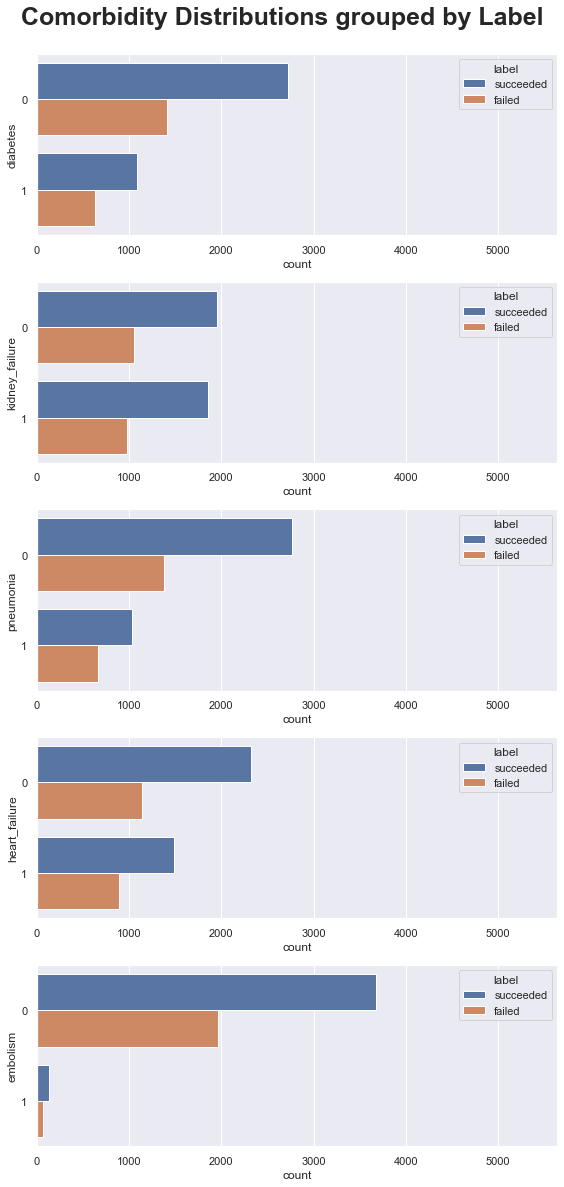

In [165]:
liste = ['diabetes', 'kidney_failure', 'pneumonia','heart_failure', 'embolism']
hue = df.label.apply(lambda x: 'succeeded' if x ==1 else 'failed')
sns.set(style="darkgrid")
fig, ax =plt.subplots(5,1, figsize=(8,16) ) 
max_count = max([max(df[i].value_counts()) for i in liste])
A=sns.countplot(y=df['diabetes'],hue=hue, ax=ax[0],order=df.diabetes.value_counts().iloc[:2].index)
B=sns.countplot(y=df['kidney_failure'],hue=hue,ax=ax[1],order=df.kidney_failure.value_counts().iloc[:2].index)
C=sns.countplot(y=df['pneumonia'],hue=hue,ax=ax[2],order=df.pneumonia.value_counts().iloc[:2].index)
D=sns.countplot(y=df['heart_failure'],hue=hue,ax=ax[3],order=df.heart_failure.value_counts().iloc[:2].index)
E=sns.countplot(y=df['embolism'],hue=hue,ax=ax[4],order=df.embolism.value_counts().iloc[:2].index)
ax[0].set_xlim(0,max_count)
ax[1].set_xlim(0,max_count)
ax[2].set_xlim(0,max_count)
ax[3].set_xlim(0,max_count)
ax[4].set_xlim(0,max_count)
fig.tight_layout()
fig.suptitle("Comorbidity Distributions grouped by Label",fontsize=25, fontweight = 'bold', y= 1.03);

## Course of certain features in the 24 hours prior to extubation